In [2]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import ipywidgets
import gensim
import re
import wordcloud

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models

In [3]:
# Import the dataset and examine its data. 

df = pd.read_csv("~/Documents/GitHub/csx4501/data/netflix_titles.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
df.sample(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
8651,s8652,Movie,Tyson,James Toback,"Mike Tyson, Trevor Berbick","United States, France","March 1, 2019",2008,R,90 min,"Documentaries, Sports Movies","In this surprisingly emotional documentary, he..."
2141,s2142,Movie,Gunjan Saxena: The Kargil Girl,Sharan Sharma,"Janhvi Kapoor, Pankaj Tripathi, Angad Bedi, Vi...",India,"August 12, 2020",2020,TV-14,113 min,"Action & Adventure, Dramas, International Movies",Flight Lieutenant Gunjan Saxena makes history ...
2129,s2130,Movie,Fearless,Cory Edwards,"Yara Shahidi, Miles Robbins, Miguel J. Pimente...",Canada,"August 14, 2020",2020,TV-Y7,92 min,"Children & Family Movies, Comedies",A teen gamer is forced to level up to full-tim...
1991,s1992,TV Show,Criminal: UK,NaN,"Katherine Kelly, Lee Ingleby, Mark Stanley, Ro...","United Kingdom, France, Germany, Spain","September 16, 2020",2020,TV-MA,2 Seasons,"British TV Shows, Crime TV Shows, Internationa...",Within the walls of an interrogation room and ...
7749,s7750,Movie,Planet Hulk,Sam Liu,"Rick D. Wasserman, Lisa Ann Beley, Mark Hildre...",United States,"June 1, 2020",2010,TV-14,81 min,"Action & Adventure, Sci-Fi & Fantasy",When Earth's superheroes exile the volatile In...
4834,s4835,Movie,Ali's Wedding,Jeffrey Walker,"Osamah Sami, Don Hany, Helana Sawires, Frances...",Australia,"June 8, 2018",2018,TV-MA,110 min,"Comedies, Independent Movies, International Mo...",After telling a white lie that spins out of co...
8464,s8465,Movie,The Prince,Brian A. Miller,"Jason Patric, Bruce Willis, John Cusack, Rain,...","United States, United Kingdom","February 22, 2019",2014,R,91 min,Action & Adventure,A former Mafia hit man living quietly as a mec...
3602,s3603,Movie,Jaoon Kahan Bata Ae Dil,Aadish Keluskar,"Khushboo Upadhyay, Rohit Kokate, Himanshu Kohl...",India,"August 9, 2019",2018,TV-MA,107 min,"Dramas, Independent Movies, International Movies","A couple’s caustic, increasingly jarring inter..."
2167,s2168,Movie,Malibu Rescue: The Next Wave,Savage Steve Holland,"Ricardo Hurtado, Breanna Yde, Jackie R. Jacobs...",United States,"August 4, 2020",2020,TV-G,71 min,"Children & Family Movies, Comedies","As summer returns to Malibu, Team Flounder tak..."
6753,s6754,Movie,Final Destination,James Wong,"Devon Sawa, Ali Larter, Kerr Smith, Kristen Cl...",United States,"January 1, 2020",2000,R,98 min,"Cult Movies, Horror Movies, Thrillers",After narrowly avoiding a fatal plane explosio...


In [6]:
# Group the data by the type column. 

movies = df[df["type"]=="Movie"]
movies.index = range(len(movies))
tv_shows = df[df["type"]=="TV Show"]
tv_shows.index = range(len(tv_shows))

In [7]:
len(movies)

6131

## Pre-processing the data
***

In [8]:
# To create a list containing all the categories of TV-shows and movies.

categories = []
for i in range(len(movies)):
    for w in movies.loc[i,'listed_in'].split(", "):
        if w not in categories:
            categories.append(w)

In [9]:
categories

['Documentaries',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'Comedies',
 'Thrillers',
 'Romantic Movies',
 'Music & Musicals',
 'Horror Movies',
 'Sci-Fi & Fantasy',
 'Action & Adventure',
 'Classic Movies',
 'Anime Features',
 'Sports Movies',
 'Cult Movies',
 'Faith & Spirituality',
 'LGBTQ Movies',
 'Stand-Up Comedy',
 'Movies']

There's a category named "Movies", which might indicate all movies without being categorized. So I dropped the data about these movies.

In [10]:
movies = movies.drop(labels=movies[movies["listed_in"]=="Movies"].index,axis=0)
movies.index = range(len(movies))

In [11]:
movies.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
2,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
3,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
4,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...
5,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,"Klara Castanho, Lucca Picon, Júlia Gomes, Marc...",NaN,"September 22, 2021",2021,TV-PG,91 min,"Children & Family Movies, Comedies",When the clever but socially-awkward Tetê join...
6,s17,Movie,Europe's Most Dangerous Man: Otto Skorzeny in ...,"Pedro de Echave García, Pablo Azorín Williams",NaN,NaN,"September 22, 2021",2020,TV-MA,67 min,"Documentaries, International Movies",Declassified documents reveal the post-WWII li...
7,s19,Movie,Intrusion,Adam Salky,"Freida Pinto, Logan Marshall-Green, Robert Joh...",NaN,"September 22, 2021",2021,TV-14,94 min,Thrillers,After a deadly home invasion at a couple’s new...
8,s23,Movie,Avvai Shanmughi,K.S. Ravikumar,"Kamal Hassan, Meena, Gemini Ganesan, Heera Raj...",NaN,"September 21, 2021",1996,TV-PG,161 min,"Comedies, International Movies",Newly divorced and denied visitation rights wi...
9,s24,Movie,Go! Go! Cory Carson: Chrissy Takes the Wheel,"Alex Woo, Stanley Moore","Maisie Benson, Paul Killam, Kerry Gudjohnsen, ...",NaN,"September 21, 2021",2021,TV-Y,61 min,Children & Family Movies,From arcade games to sled days and hiccup cure...


In [14]:
directors = {}
for i in range(len(movies)):
    if movies.loc[i,'director'] not in directors:
        directors[movies.loc[i,'director']] = 1
    else:
        directors[movies.loc[i,'director']] += 1

In [36]:
top_15_directors = sorted(directors.items(),key=lambda s:s[1],reverse=True)[1:16]

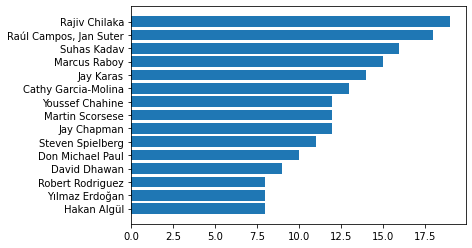

In [53]:
fig,ax = plt.subplots()
top_15 = [i[0] for i in top_15_directors]
movie_num = [j[1] for j in top_15_directors]
ax.barh(top_15,movie_num)
ax.invert_yaxis()
plt.show()

In [42]:
categories = []
for i in range(len(movies)):
    for w in movies.loc[i,'listed_in'].split(", "):
        if w not in categories:
            categories.append(w)

In [43]:
NumberByTypes = []
for i in range(len(categories)):
    count = 0
    for x in range(len(movies)):
        if categories[i] in movies.loc[x,'listed_in'].split(", "):
            count += 1
    NumberByTypes.append(count)

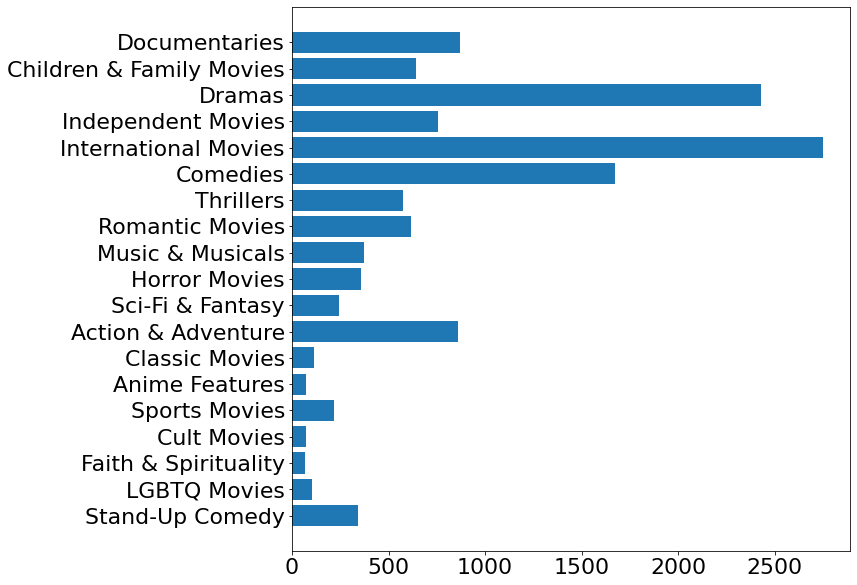

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(categories,NumberByTypes)
ax.invert_yaxis()
plt.tick_params(labelsize=22)

In [16]:
myStopWords = list(punctuation) + stopwords.words('english')

In [17]:
word_tokenize(movies.loc[1,'description'])

['Equestria',
 "'s",
 'divided',
 '.',
 'But',
 'a',
 'bright-eyed',
 'hero',
 'believes',
 'Earth',
 'Ponies',
 ',',
 'Pegasi',
 'and',
 'Unicorns',
 'should',
 'be',
 'pals',
 '—',
 'and',
 ',',
 'hoof',
 'to',
 'heart',
 ',',
 'she',
 '’',
 's',
 'determined',
 'to',
 'prove',
 'it',
 '.']

## Produce tags for movies based on their descriptions
***
Categories are usually helpful for audience to get an initial impression about the movie. However, as the time passes by, a particular category of movie may involve different elements. Moreover, posting some tags below the name of each category is also a useful way to allow the audience to find their favorite movie type. 

In [62]:
## To create a list to include the tokneized description for all movies. 

descriptions = [word_tokenize(movies.loc[i,'description']) for i in range(len(movies))]

In [63]:
## To get rid of the stopwords and punctuation.

myStopWords = list(punctuation) + stopwords.words('english')
desc = []
for i in descriptions:
    temp_list = [w for w in i if w not in myStopWords]
    desc.append(temp_list)

In [64]:
## Using PorterStemmer to stem the words in descriptions. 

p_stemmer = PorterStemmer()
desc_stemmed = []
for i in desc:
    desc_stemmed.append([p_stemmer.stem(w) for w in i])

In [65]:
# To create a list to store the descriptions of movies from different categories. 

DescByTypes = []
for i in range(len(categories)):
    DescByTypes.append([movies.loc[x,'description'] for x in range(len(movies)) if categories[i] in movies.loc[x,'listed_in'].split(', ')])

In [66]:
Documentaries = DescByTypes[1]

In [67]:
Docu = []
for i in Documentaries:
    Docu.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])

In [68]:
p_stemmer = PorterStemmer()
Docu_stemmed = []
for i in Docu:
    Docu_stemmed.append([p_stemmer.stem(w) for w in i])

In [69]:
dictionary = corpora.Dictionary(Docu_stemmed)

In [70]:
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [71]:
print(dictionary.token2id)

{"'s": 0, 'determin': 1, 'earth': 2, 'heart': 3, 'hero': 4, 'pal': 5, 'prove': 6, '—': 7, '’': 8, "'ll": 9, 'join': 10, 'new': 11, 'queen': 12, 'school': 13, 'adventur': 14, 'cori': 15, 'curiou': 16, 'day': 17, 'fun': 18, 'game': 19, 'littl': 20, 'sister': 21, 'town': 22, 'everi': 23, 'friend': 24, 'magic': 25, 'must': 26, 'night': 27, 'scari': 28, 'stori': 29, 'tale': 30, 'trap': 31, 'witch': 32, 'kid': 33, 'mission': 34, 'search': 35, 'space': 36, 'travel': 37, 'bear': 38, 'crash': 39, 'interact': 40, 'leav': 41, 'make': 42, 'miss': 43, 'save': 44, 'surviv': 45, 'cop': 46, 'defeat': 47, 'demon': 48, 'enemi': 49, 'evil': 50, 'help': 51, 'lose': 52, 'plan': 53, 'singham': 54, 'stop': 55, 'superpow': 56, 'tri': 57, 'dragon': 58, 'fli': 59, 'home': 60, 'human': 61, 'live': 62, 'seek': 63, 'summon': 64, 'threaten': 65, 'young': 66, 'agent': 67, 'babi': 68, 'dog': 69, 'go': 70, 'pet': 71, 'show': 72, 'care': 73, 'heal': 74, 'hors': 75, 'teen': 76, 'work': 77, 'boy': 78, 'bring': 79, 'danc'

In [28]:
corpus = [dictionary.doc2bow(text) for text in Docu_stemmed]

In [29]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5)

In [30]:
ldamodel.show_topics(num_topics=1)

[(0,
  '0.039*"documentari" + 0.030*"\'s" + 0.012*"life" + 0.010*"world" + 0.010*"explor" + 0.010*"follow" + 0.009*"``" + 0.009*"\'\'" + 0.009*"film" + 0.007*"stori"')]

In [31]:
# Now let's create such lists for each movie category. 

myStopWords = list(punctuation) + stopwords.words('english')
ctg_des = []
for c in range(len(categories)):
    descriptions = [word_tokenize(DescByTypes[c][i]) for i in range(len(DescByTypes[c]))]
    descriptions_flatten = [a for b in descriptions for a in b]
    temp_list = [w for w in descriptions_flatten if w not in myStopWords]
    ctg_des.append(temp_list)

In [32]:
p_stemmer = PorterStemmer()
des_stemmed = []
for i in ctg_des:
    des_stemmed.append([p_stemmer.stem(w) for w in i])

In [33]:
def visualize(m):
    Desc = []
    for i in DescByTypes[m]:
        Desc.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])
    p_stemmer = PorterStemmer()
    Desc_stemmed = []
    for i in Desc:
        Desc_stemmed.append([p_stemmer.stem(w) for w in i])
    dictionary = corpora.Dictionary(Desc_stemmed)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in Desc_stemmed]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)
    fig,ax = plt.subplots()

    x = []
    y = []
    count = 0
    for i in re.split(re.escape(' + ') + '|' + re.escape('*'), ldamodel.print_topics(num_topics=1, num_words=20)[0][1]):
        if count % 2 == 0:
            y.insert(0,float(i))
        else:
            x.insert(0,i)
        count += 1
    ax.barh(x,y,height=0.5)
    plt.tight_layout()
ipywidgets.interact(visualize,m=(0,18))

interactive(children=(IntSlider(value=9, description='m', max=18), Output()), _dom_classes=('widget-interact',…

<function __main__.visualize(m)>

Through observation, I found the "'s" should be removed from the 

In [79]:
myStopWords.extend(["'s","'","·","``",'"','—'])

In [87]:
DescByTypes = []
for i in range(len(categories)):
    DescByTypes.append([movies.loc[x,'description'] for x in range(len(movies)) if categories[i] in movies.loc[x,'listed_in'].split(', ')])
def visualize(m):
    Desc = []
    for i in DescByTypes[m]:
        Desc.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])
    p_stemmer = PorterStemmer()
    Desc_stemmed = []
    for i in Desc:
        Desc_stemmed.append([p_stemmer.stem(w) for w in i])
    dictionary = corpora.Dictionary(Desc_stemmed)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in Desc_stemmed]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)
    fig,ax = plt.subplots()

    x = []
    y = []
    count = 0
    for i in re.split(re.escape(' + ') + '|' + re.escape('*'), ldamodel.print_topics(num_topics=1, num_words=20)[0][1]):
        if count % 2 == 0:
            y.insert(0,float(i))
        else:
            x.insert(0,i)
        count += 1
    ax.barh(x,y,height=0.5)
    plt.tight_layout()
ipywidgets.interact(visualize,m=(0,18))

interactive(children=(IntSlider(value=9, description='m', max=18), Output()), _dom_classes=('widget-interact',…

<function __main__.visualize(m)>

In [94]:
def visualize(m):
    Desc = []
    for i in DescByTypes[m]:
        Desc.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])
    p_stemmer = PorterStemmer()
    Desc_stemmed = []
    for i in Desc:
        Desc_stemmed.append([p_stemmer.stem(w) for w in i])
    dictionary = corpora.Dictionary(Desc_stemmed)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in Desc_stemmed]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)

    x = []
    y = []
    count = 0
    for i in re.split(re.escape(' + ') + '|' + re.escape('*'), ldamodel.print_topics(num_topics=1, num_words=20)[0][1]):
        if count % 2 == 0:
            y.insert(0,float(i))
        else:
            x.insert(0,i)
        count += 1
    plt.figure(figsize=(20,20))
    frequencies = {}
    for a in x:
        frequencies[a]=y[x.index(a)]
    plt.title('The topics from different types of movies\n', fontsize=30, weight=600, color='#333d29')
    wc = wordcloud.WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(x))
    word_cloud = wc.generate_from_frequencies(frequencies)

    plt.imshow(wc)
ipywidgets.interact(visualize,m=(0,18))


interactive(children=(IntSlider(value=9, description='m', max=18), Output()), _dom_classes=('widget-interact',…

<function __main__.visualize(m)>

In [39]:
x = []
y = []
count = 0
for i in re.split(re.escape(' + ') + '|' + re.escape('*'), ldamodel.print_topics(num_topics=1, num_words=20)[0][1]):
    if count % 2 == 0:
        y.insert(0,float(i))
    else:
        x.insert(0,i)
    count += 1